In [116]:
#setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from itertools import cycle

from datetime import datetime

from tqdm import tqdm

from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern

## Load the data

In [2]:
!curl https://projects.fivethirtyeight.com/nba-model/nba_elo.csv -o nba_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9250k  100 9250k    0     0  3984k      0  0:00:02  0:00:02 --:--:-- 3984k


In [26]:
df = pd.read_csv('nba_data.csv')

In [27]:
df.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,carm-elo_prob1,carm-elo_prob2,carm-elo1_post,carm-elo2_post,raptor1_pre,raptor2_pre,raptor_prob1,raptor_prob2,score1,score2
0,1946-11-01,1947,0,NaN,TRH,NYK,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,68.0
1,1946-11-02,1947,0,NaN,CHS,NYK,1300.0,1306.7233,0.631101,0.368899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,47.0
2,1946-11-02,1947,0,NaN,PRO,BOS,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,53.0
3,1946-11-02,1947,0,NaN,STB,PIT,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,51.0
4,1946-11-02,1947,0,NaN,DTF,WSC,1300.0,1300.0000,0.640065,0.359935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,50.0


We'll use only date, season, teams, scores, and post game elos.

In [28]:
df = df[['date', 'season', 'team1', 'team2', 'score1', 'score2', 'elo1_post', 'elo2_post']]
df.head()

,date,season,team1,team2,score1,score2,elo1_post,elo2_post
0,1946-11-01,1947,TRH,NYK,66.0,68.0,1293.2767,1306.7233
1,1946-11-02,1947,CHS,NYK,63.0,47.0,1309.6521,1297.0712
2,1946-11-02,1947,PRO,BOS,59.0,53.0,1305.1542,1294.8458
3,1946-11-02,1947,STB,PIT,56.0,51.0,1304.6908,1295.3092
4,1946-11-02,1947,DTF,WSC,33.0,50.0,1279.6189,1320.3811


## Advantage of playing at home
We assume that playing it's more common for a home team to win. Let's check if that's correct and if so, how crutial it is.

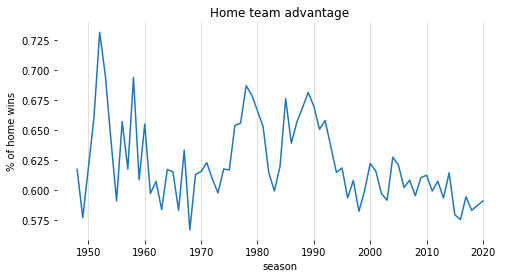

In [5]:
last_s = df.iloc[0]['season']
gp = home_w = 0
x, y = [], []

for i in range(len(df)):
    row = df.iloc[i]
    
    s = row['season']
    
    if s != last_s:
        x.append(s)
        y.append(home_w / gp)
        gp = home_w = 0
    
    if row['score1'] > row['score2']:
        home_w += 1
    gp += 1
    
    last_s = s
    
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title('Home team advantage')
ax.set_xlabel('season')
ax.set_ylabel('% of home wins')
for spine in ('top', 'bottom', 'right', 'left'):
    ax.spines[spine].set_visible(False)
ax.grid(axis='x', alpha=0.5)
ax.plot(x, y)
None

In last 10 years home team is winning about 60% of games. We should create a constant telling us advantage given to the team by playing at home. Adding 35 Elo Rating points works the best when optimizing accuracy of the model and money made on betting.

In [39]:
home_team_adv = 35

## Create skill function for each team
Using ratings of each team at the beginning of the month we'll fit a Gaussian Process Regression using Matern kernel with some noise.

In [40]:
teams = np.unique(np.append(df['team1'], df['team2']))

In [104]:
def plot_skills(items, figsize=(14.0, 3.0), title='Evolution of skill of NBA teams', xlims=None):
    colors = cycle(plt.cm.tab10(np.linspace(0, 1, 10)))
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.set_title(title)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    ax.grid(axis='x', alpha=0.5)
    
    if xlims is not None:
        xmin = datetime.fromisoformat(xlims[0]).timestamp()
        xmax = datetime.fromisoformat(xlims[1]).timestamp()
    
    if isinstance(items, list):
        for team in items:
            color = next(colors)
            gpr = gprs[team]
            dates = df[(df['team1'] == team) | (df['team2'] == team)]['date']
        
            dates = [datetime.fromisoformat(el).timestamp() for el in dates]
            if xlims == None:
                x = np.linspace(min(dates), max(dates), 1000).reshape(-1, 1)
            else:
                x = np.linspace(max(min(dates), xmin), min(max(dates), xmax), 1000).reshape(-1, 1)
            y, std = gpr.predict(x, return_std=True)

            x = [datetime.fromtimestamp(t) for t in x]
            ax.plot(x, y, color=color, label=team)
            ax.fill_between(x, y-std, y+std, color=color, alpha=0.2)
        ax.legend()
    else:
        team = items
        gpr = gprs[team]
        dates = df[(df['team1'] == team) | (df['team2'] == team)]['date']
        
        dates = [datetime.fromisoformat(el).timestamp() for el in dates]
        if xlims == None:
            x = np.linspace(min(dates), max(dates), 1000).reshape(-1, 1)
        else:
            x = np.linspace(max(min(dates), xmin), min(max(dates), xmax), 1000).reshape(-1, 1)
        y = gpr.predict(x)
        
        x = [datetime.fromtimestamp(t) for t in x]
        ax.plot(x, y, label=team)
        ax.legend()
        

def fit_gpr(train_x, train_y, test_x, kernel, return_gpr=False):
    if isinstance(train_x, list):
        train_x = np.array(train_x).reshape(-1, 1)
    if isinstance(test_x, list):
        test_x = np.array(test_x).reshape(-1, 1)
    gpr = GaussianProcessRegressor(kernel=kernel, copy_X_train=False)
    gpr.fit(train_x, train_y)
    
    if len(test_x):
        test_y = gpr.predict(test_x)
    else:
        test_y = None
    
    if return_gpr:
        return test_y, gpr.kernel_, gpr
    else:
        return test_y, gpr.kernel_

In [147]:
l_scale = 5 * 365.25 * 24 * 60 * 60
noise = 0.1
kernel = Matern(nu=5/2, length_scale=l_scale, length_scale_bounds=(l_scale/10, l_scale*10)) + \
        WhiteKernel(noise_level=noise, noise_level_bounds=(noise, noise))

In [148]:
gprs = defaultdict(object)
for team in tqdm(teams):
    dates = np.append(df[df['team1'] == team]['date'], df[df['team2'] == team]['date'])
    e = np.append(df[df['team1'] == team]['elo1_post'], df[df['team2'] == team]['elo2_post'])
    
    idx = dates < '2020'
    dates = dates[idx]
    e = e[idx]
    
    idx = np.argsort(dates)
    dates = dates[idx]
    e = e[idx]
    
    dates = np.array([datetime.fromisoformat(el).timestamp() for el in dates])
    e -= 1500

    months = np.array(list(map(lambda x: datetime.fromtimestamp(x).month, dates)))
    idx = np.nonzero(months[1:] != months[:-1])[0]
    
    train_x = dates[idx].reshape(-1, 1)
    train_y = e[idx]


    _, _, gpr = fit_gpr(train_x, train_y, [], kernel, return_gpr=True)
    
    gprs[team] = gpr

100%|██████████| 102/102 [00:05<00:00, 20.13it/s]


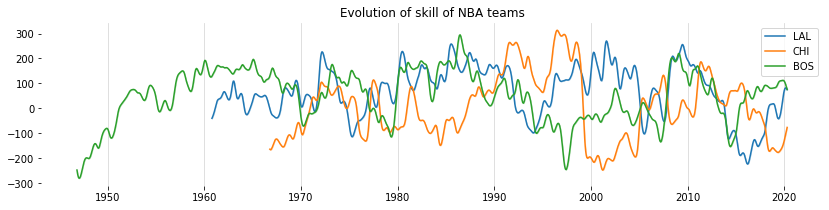

In [149]:
plot_skills(['LAL', 'CHI', 'BOS'])

## Check the accuracy of our predictor

In [150]:
def predict_result(team1, team2, t):
    if isinstance(t, list):
        # make multiple predictions for those 2 teams
        if isinstance(t[0], str):
            for i in range(len(t)):
                t[i] = datetime.fromisoformat(t[i]).timestamp()
        
        t = np.array(t).reshape(-1, 1)
        
        skills1 = gprs[team1].predict(t)
        skills2 = gprs[team2].predict(t)
        skills1 += home_team_adv
        
        res = np.full(len(t), team1)
        res[skills1 < skills2] = team2
        return res
        
    else:
        if isinstance(t, str):
            t = datetime.fromisoformat(t).timestamp()

        t = np.array(t).reshape(-1, 1)
        skill1 = gprs[team1].predict(t)
        skill2 = gprs[team2].predict(t)
        skill1 += home_team_adv

        if skill1 > skill2:
            return team1
        else:
            return team2

In [151]:
confussion_matrix = np.zeros((2, 2))

for i in tqdm(range(len(df))):
    row = df.iloc[i]
    if row['season'] < 1950:
        continue
    
    if row['score1'] > row['score2']:
        home_w = True
        result = row['team1']
    else:
        home_w = False
        result = row['team2']
    
    pred = predict_result(row['team1'], row['team2'], row['date'])
    
    if home_w:
        if result == pred:
            confussion_matrix[0][0] += 1
        else:
            confussion_matrix[0][1] += 1
    else:
        if result == pred:
            confussion_matrix[1][1] += 1
        else:
            confussion_matrix[1][0] += 1

100%|██████████| 69635/69635 [00:46<00:00, 1511.84it/s]


In [152]:
print(f'Confussion matrix:\n{confussion_matrix}\nAccuracy: \
{np.sum(np.diag(confussion_matrix)) / np.sum(confussion_matrix)}')

Confussion matrix:
[[30809. 11409.]
 [10109. 16363.]]
Accuracy: 0.6867375163779298


Accuracy seems to be quite good but from the testing notebook we know that selecting a team with higher Elo Rating as a winner provided 66% accuracy with similar confussion matrix.

## To know if the predictor provides us with useful data, check if we'll will make any money betting on every game \\$10.

In [153]:
games_df = pd.read_csv('data/nba_games_all.csv')
lines_df = pd.read_csv('data/nba_betting_money_line.csv')

In [154]:
games_df = games_df[games_df['is_home'] == 'f']
book = lines_df['book_name'].value_counts().index[0]
lines_df = lines_df[lines_df['book_name'] == book]

In [155]:
lg_df = games_df.merge(lines_df, on='game_id')
lg_df[lg_df['season_year'] == 2017].head()

,game_id,game_date,matchup,team_id_x,is_home,wl,w,l,w_pct,min,...,a_team_id_x,season_year,season_type,season,book_name,book_id,team_id_y,a_team_id_y,price1,price2
670,41700232,2018-05-01,GSW vs. NOP,1610612740,f,L,0.0,2.0,0.000,240,...,1610612744,2017,Playoffs,2017-18,5Dimes,19,1610612740,1610612744,600.0,-750.0
2775,21701028,2018-03-15,POR vs. CLE,1610612739,f,L,39.0,29.0,0.574,240,...,1610612757,2017,Regular Season,2017-18,5Dimes,19,1610612739,1610612757,210.0,-230.0
2776,21700850,2018-02-13,OKC vs. CLE,1610612739,f,W,34.0,22.0,0.607,240,...,1610612760,2017,Regular Season,2017-18,5Dimes,19,1610612739,1610612760,140.0,-150.0
2777,21700559,2018-01-03,BOS vs. CLE,1610612739,f,L,25.0,13.0,0.658,240,...,1610612738,2017,Regular Season,2017-18,5Dimes,19,1610612739,1610612738,135.0,-145.0
2778,21700453,2017-12-19,MIL vs. CLE,1610612739,f,L,23.0,9.0,0.719,240,...,1610612749,2017,Regular Season,2017-18,5Dimes,19,1610612739,1610612749,-105.0,-105.0


In [156]:
def money_boost(line):
    if line < 0:
        return 100 * (our_bet / -line)
    else:
        return line / (100 / our_bet)
    
money_s = defaultdict(int)
money_d = defaultdict(int)
our_bet = 10
n = 0
opt_max_line = 250

for i in tqdm(range(len(lg_df)), position=0, leave=True):
    row = lg_df.iloc[i]
    t = row['game_date']
    s = row['season']
    t1, t2 = row['matchup'].split(' vs. ')
    
    if t1 not in teams or t2 not in teams:
        continue
        
    if row['price1'] > opt_max_line or row['price2'] > opt_max_line:
        continue
        
    pred = predict_result(t1, t2, t)
    n += 1
    
    if pred == t2 and row['wl'] == 'W':
        money_d[t] += money_boost(row['price1'])
        money_s[s] += money_boost(row['price1'])
    elif pred == t1 and row['wl'] == 'L':
        money_d[s] += money_boost(row['price2'])
        money_s[s] += money_boost(row['price2'])
    else:
        money_d[s] -= our_bet
        money_s[s] -= our_bet

100%|██████████| 14894/14894 [00:08<00:00, 1805.63it/s]


In [174]:
print(f'Total money made: ${round(sum(money_d.values()), 2)}, first bet placed: {min(money_d.keys())}, last: {max(money_d.keys())}')
print(f'Average money made from one bet: ${round(sum(money_s.values()) / n, 2)}, bets taken: {n}, bets skipped: {len(lg_df) - n}')
print(f'Average money made in one day: ${round(sum(money_d.values()) / len(money_d.values()), 2)}')
print(f'Average money made in a season: ${round(sum(money_s.values()) / len(money_s.values()), 2)}')

max_s_idx = np.argmax(list(money_s.values()))
min_s_idx = np.argmin(list(money_s.values()))

print(f'The worst season was {list(money_s.keys())[min_s_idx]} with ${round(list(money_s.values())[min_s_idx], 2)} made, \
the best season - {list(money_s.keys())[max_s_idx]} with ${round(list(money_s.values())[max_s_idx], 2)} made')

Total money made: $4413.03, first bet placed: 2006-07, last: 2018-05-06
Average money made from one bet: $0.59, bets taken: 7526, bets skipped: 7368
Average money made in one day: $3.14
Average money made in a season: $367.75
The worst season was 2017-18 with $83.06 made, the best season - 2007-08 with $627.0 made


From each \\$10 we were able to make about \\$0.6 which gives us 6%. Accuracy from basic comparing Elo Ratings may be similar to accuracy given by our model but it's completely useless - we would lost \\$1700 using that technique.

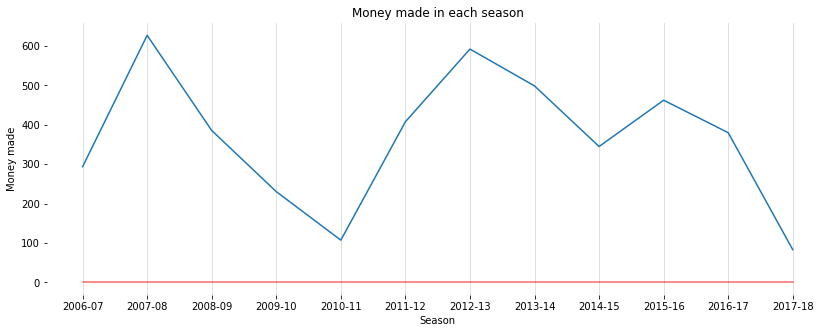

In [159]:
x, y = [], []
for k, v in money_s.items():
    x.append(k)
    y.append(v)
    
x = np.array(x)
y = np.array(y)
idx = np.argsort(x)
x = x[idx]
y = y[idx]

fig, ax = plt.subplots(figsize=(14, 5))
ax.set_title('Money made in each season')
ax.set_xlabel('Season')
ax.set_ylabel('Money made')
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
ax.grid(axis='x', alpha=0.5)

ax.plot(x, y)
ax.plot(x, np.zeros(x.shape), color='r', alpha=0.6)
None